In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import mean as _mean, stddev as _stddev
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = (
    SparkSession.builder
    .appName("StockML")
    .config("spark.driver.memory", "8g")     
    .config("spark.executor.memory", "8g")    
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "4g")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/23 12:38:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
stock_raw_df = spark.read.csv("./stock_details_5_years.csv",header=True,inferSchema=True)
print("Initial rows count:", stock_raw_df.count())
stock_raw_df.show(5)

Initial rows count: 602962
+-------------------+----------------+----------------+----------------+----------------+---------+---------+------------+-------+
|               Date|            Open|            High|             Low|           Close|   Volume|Dividends|Stock Splits|Company|
+-------------------+----------------+----------------+----------------+----------------+---------+---------+------------+-------+
|2018-11-29 00:00:00| 43.829760572993|43.8633538041636|42.6395935832266|43.0835075378418|167080000|      0.0|         0.0|   AAPL|
|2018-11-29 00:00:00|104.769074332185|105.519257086357|103.534594914971|104.636131286621| 28123200|      0.0|         0.0|   MSFT|
|2018-11-29 00:00:00|54.1764984130859|55.0074996948242|54.0999984741211|54.7290000915527| 31004000|      0.0|         0.0|  GOOGL|
|2018-11-29 00:00:00|83.7494964599609|84.4994964599609|82.6165008544922|83.6784973144531|132264000|      0.0|         0.0|   AMZN|
|2018-11-29 00:00:00|39.6927840259795|40.0649038762231|3

In [4]:
missing_df = stock_raw_df.select([
    count(when(col(c).isNull(), c)).alias(c + "_missing")
    for c in stock_raw_df.columns
])

missing_df.show(truncate=False)

+------------+------------+------------+-----------+-------------+--------------+-----------------+--------------------+---------------+
|Date_missing|Open_missing|High_missing|Low_missing|Close_missing|Volume_missing|Dividends_missing|Stock Splits_missing|Company_missing|
+------------+------------+------------+-----------+-------------+--------------+-----------------+--------------------+---------------+
|0           |0           |0           |0          |0            |0             |0                |0                   |0              |
+------------+------------+------------+-----------+-------------+--------------+-----------------+--------------------+---------------+



In [5]:
stock_clean_df = stock_raw_df.withColumn("Date", to_timestamp("Date"))
stock_clean_df.show(10)

+-------------------+----------------+----------------+----------------+----------------+---------+---------+------------+-------+
|               Date|            Open|            High|             Low|           Close|   Volume|Dividends|Stock Splits|Company|
+-------------------+----------------+----------------+----------------+----------------+---------+---------+------------+-------+
|2018-11-29 00:00:00| 43.829760572993|43.8633538041636|42.6395935832266|43.0835075378418|167080000|      0.0|         0.0|   AAPL|
|2018-11-29 00:00:00|104.769074332185|105.519257086357|103.534594914971|104.636131286621| 28123200|      0.0|         0.0|   MSFT|
|2018-11-29 00:00:00|54.1764984130859|55.0074996948242|54.0999984741211|54.7290000915527| 31004000|      0.0|         0.0|  GOOGL|
|2018-11-29 00:00:00|83.7494964599609|84.4994964599609|82.6165008544922|83.6784973144531|132264000|      0.0|         0.0|   AMZN|
|2018-11-29 00:00:00|39.6927840259795|40.0649038762231|38.7351954599368|39.03785324

In [6]:
numeric_cols = [
    "Open", "High", "Low", "Close",
    "Volume", "Dividends", "Stock Splits"
]

for colname in numeric_cols:
    stock_clean_df = stock_clean_df.withColumn(
        colname,
        col(colname).cast("double")
)

In [7]:
stock_clean_df.show(10)

+-------------------+----------------+----------------+----------------+----------------+---------+---------+------------+-------+
|               Date|            Open|            High|             Low|           Close|   Volume|Dividends|Stock Splits|Company|
+-------------------+----------------+----------------+----------------+----------------+---------+---------+------------+-------+
|2018-11-29 00:00:00| 43.829760572993|43.8633538041636|42.6395935832266|43.0835075378418| 1.6708E8|      0.0|         0.0|   AAPL|
|2018-11-29 00:00:00|104.769074332185|105.519257086357|103.534594914971|104.636131286621|2.81232E7|      0.0|         0.0|   MSFT|
|2018-11-29 00:00:00|54.1764984130859|55.0074996948242|54.0999984741211|54.7290000915527| 3.1004E7|      0.0|         0.0|  GOOGL|
|2018-11-29 00:00:00|83.7494964599609|84.4994964599609|82.6165008544922|83.6784973144531|1.32264E8|      0.0|         0.0|   AMZN|
|2018-11-29 00:00:00|39.6927840259795|40.0649038762231|38.7351954599368|39.03785324

In [8]:
stock_clean_df = stock_clean_df.dropDuplicates()
stock_clean_df = stock_clean_df.dropna(subset=["Company", "Date"])

In [9]:
means = stock_clean_df.select([
    mean(col(c)).alias(c) for c in numeric_cols
]).collect()[0]

for c in numeric_cols:
    stock_clean_df = stock_clean_df.fillna({c: means[c]})

In [10]:
stock_clean_df = stock_clean_df.orderBy(["Company", "Date"])

In [11]:
stats = stock_clean_df.select(
    _mean(col("Volume")).alias("mean_vol"),
    _stddev(col("Volume")).alias("std_vol")
).collect()[0]

mean_vol = stats["mean_vol"]
std_vol = stats["std_vol"]

stock_clean_df = stock_clean_df.withColumn(
    "z_volume",
    (col("Volume") - mean_vol) / std_vol
)

outliers_df = stock_clean_df.filter(abs(col("z_volume")) > 3)

print("Potential volume outliers:", outliers_df.count())


Potential volume outliers: 10077


In [12]:
no_of_companies = stock_clean_df.select("Company").distinct().count()
print("Number of companies:", no_of_companies)

Number of companies: 491


### EDA

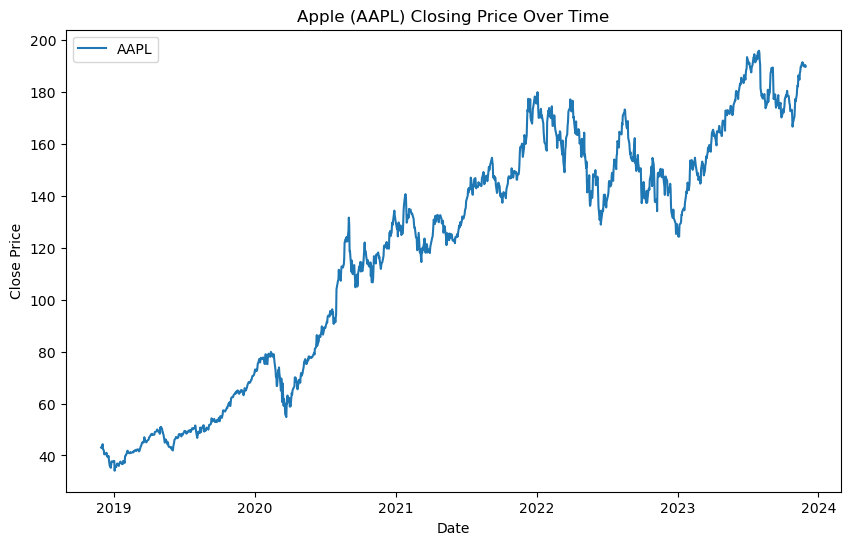

In [13]:
apple = stock_clean_df.filter(col("Company") == "AAPL")
apple_pd = apple.toPandas()

plt.figure(figsize=(10,6))
plt.plot(apple_pd['Date'], apple_pd['Close'], label='AAPL')
plt.title("Apple (AAPL) Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

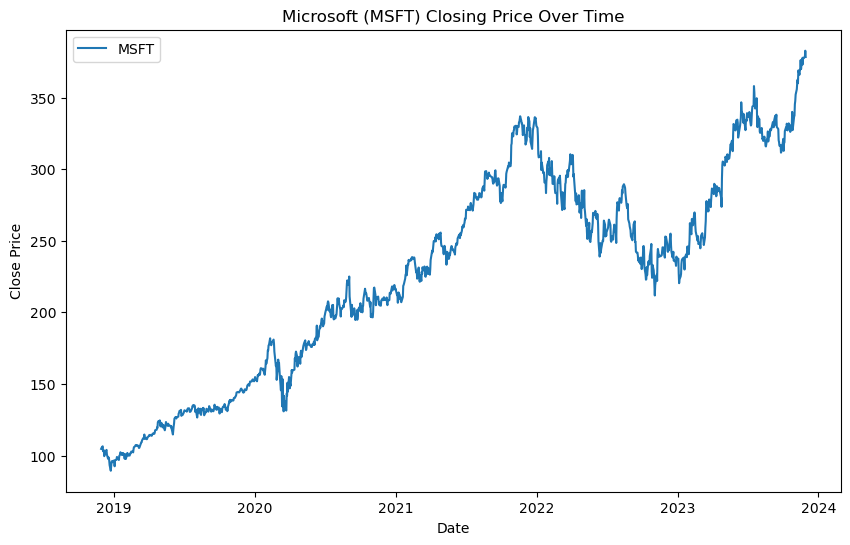

In [14]:
microsoft = stock_clean_df.filter(col("Company") == "MSFT")
microsoft_pd = microsoft.toPandas()
plt.figure(figsize=(10,6))
plt.plot(microsoft_pd['Date'], microsoft_pd['Close'], label='MSFT')
plt.title("Microsoft (MSFT) Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

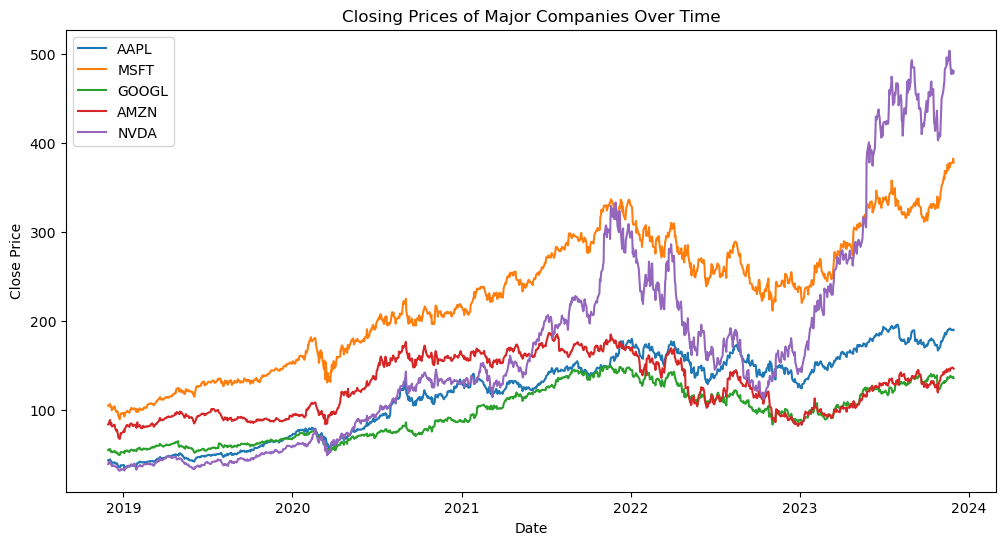

In [15]:
dream_companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
plt.figure(figsize=(12,6))
for comp in dream_companies:
    subset = stock_clean_df.filter(col("Company") == comp).toPandas()
    plt.plot(subset['Date'], subset['Close'], label=comp)

plt.title("Closing Prices of Major Companies Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [16]:
stock_clean_df.describe().show()

25/11/23 12:39:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 108:>                                                      (0 + 12) / 12]

+-------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+-------------------+-------+--------------------+
|summary|              Open|             High|              Low|             Close|              Volume|           Dividends|       Stock Splits|Company|            z_volume|
+-------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+-------------------+-------+--------------------+
|  count|            602962|           602962|           602962|            602962|              602962|              602962|             602962| 602962|              602962|
|   mean|140.07471066817286| 141.853491727592|138.2763164581295|140.09520381512718|   5895601.184908833|0.007309695111798087|3.44262988380694E-4|   NULL|-1.18407684214220...|
| stddev|   275.40172508862|279.0031910396211|271.8952763570855|275.47796892551224|1.3815961832517486E7| 0.12056968318802695|

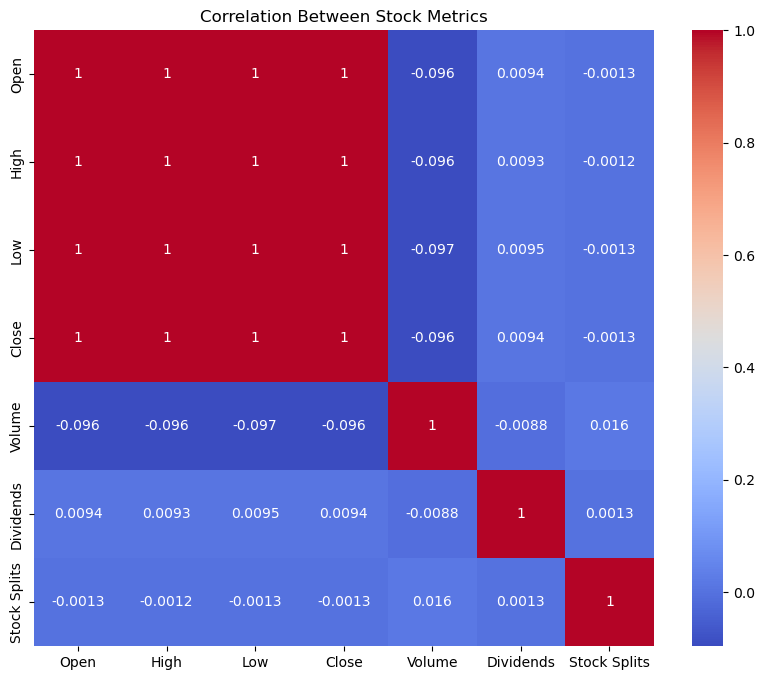

In [17]:
numeric_cols = ["Open","High","Low","Close","Volume","Dividends","Stock Splits"]
corr_matrix = stock_clean_df.select(numeric_cols).toPandas().corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Stock Metrics")
plt.show()

In [18]:
w = Window.partitionBy("Company").orderBy("Date")

stock_clean_df = stock_clean_df.withColumn(
    "Daily_Return",
    (col("Close") - lag("Close").over(w)) / lag("Close").over(w) * 100
)

In [19]:
volatility = stock_clean_df.groupBy("Company") \
    .agg(stddev("Daily_Return").alias("Volatility")) \
    .orderBy(col("Volatility").desc())

volatility.show(10)

+-------+------------------+
|Company|        Volatility|
+-------+------------------+
|    SYM|7.0969453105021945|
|   COIN| 5.724516825226692|
|   BNTX| 5.649818191409452|
|   BEKE|  5.62419417656523|
|   RBLX| 5.216142009910055|
|   SNAP| 4.866491525810489|
|     LI|4.8206238264732955|
|    PCG| 4.787881360711023|
|    PDD| 4.726728061609512|
|   MRNA| 4.726710788907268|
+-------+------------------+
only showing top 10 rows


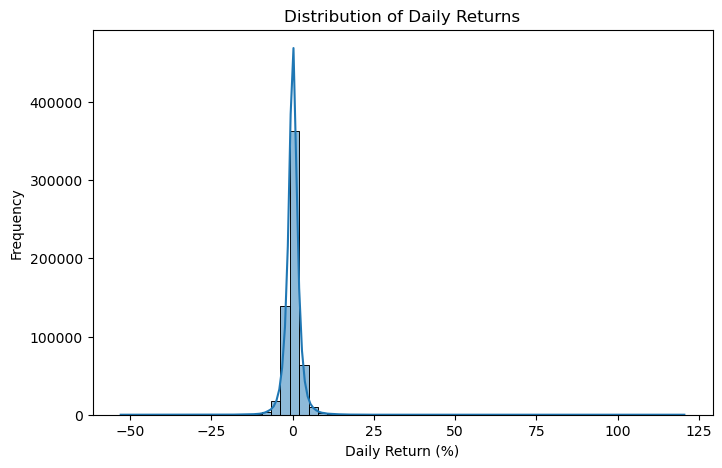

In [20]:
returns_pd = stock_clean_df.select("Daily_Return").dropna().toPandas()
plt.figure(figsize=(8,5))
sns.histplot(returns_pd['Daily_Return'], bins=60, kde=True)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency")
plt.show()

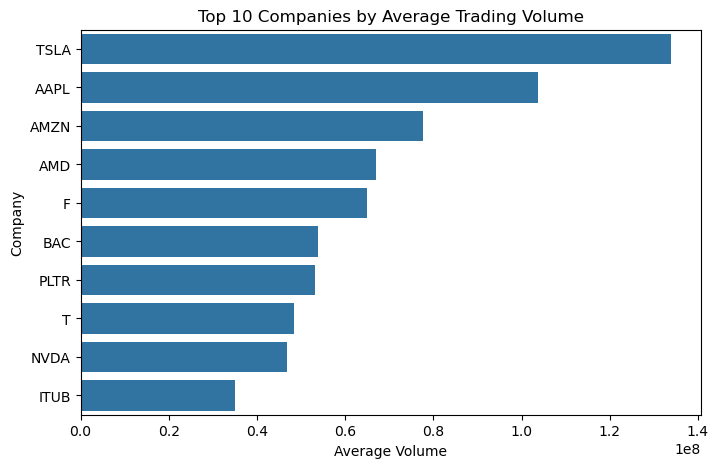

In [21]:
avg_volume = stock_clean_df.groupBy("Company").agg(mean("Volume").alias("AvgVolume")).orderBy(col("AvgVolume").desc()).limit(10)
avg_volume_pd = avg_volume.toPandas()
plt.figure(figsize=(8,5))
sns.barplot(x=avg_volume_pd['AvgVolume'], y=avg_volume_pd['Company'])
plt.title("Top 10 Companies by Average Trading Volume")
plt.xlabel("Average Volume")
plt.ylabel("Company")
plt.show()

In [22]:
stock_ts = stock_clean_df.withColumn("Year", year(col("Date"))).withColumn("Month", date_format(col("Date"), "yyyy-MM")).withColumn("Week", weekofyear(col("Date")))
monthly_avg = stock_ts.groupBy("Company", "Month").agg(avg("Close").alias("Avg_Close")).orderBy("Company", "Month")
monthly_avg.show(20)

+-------+-------+-----------------+
|Company|  Month|        Avg_Close|
+-------+-------+-----------------+
|      A|2018-11| 69.3772430419922|
|      A|2018-12|66.12870527568616|
|      A|2019-01|68.06317810785204|
|      A|2019-02|74.81009473298725|
|      A|2019-03| 77.3640619913737|
|      A|2019-04|76.56575230189733|
|      A|2019-05|69.87017371437766|
|      A|2019-06| 68.7646671295166|
|      A|2019-07|69.47513961791992|
|      A|2019-08|67.26569626548073|
|      A|2019-09| 73.6542537689209|
|      A|2019-10|72.89751832381539|
|      A|2019-11|75.86534461975097|
|      A|2019-12|81.29544321695964|
|      A|2020-01|84.93444279261998|
|      A|2020-02| 80.8236168309262|
|      A|2020-03|69.78702597184615|
|      A|2020-04|73.97302028111051|
|      A|2020-05|79.44533271789551|
|      A|2020-06|86.44157548384233|
+-------+-------+-----------------+
only showing top 20 rows


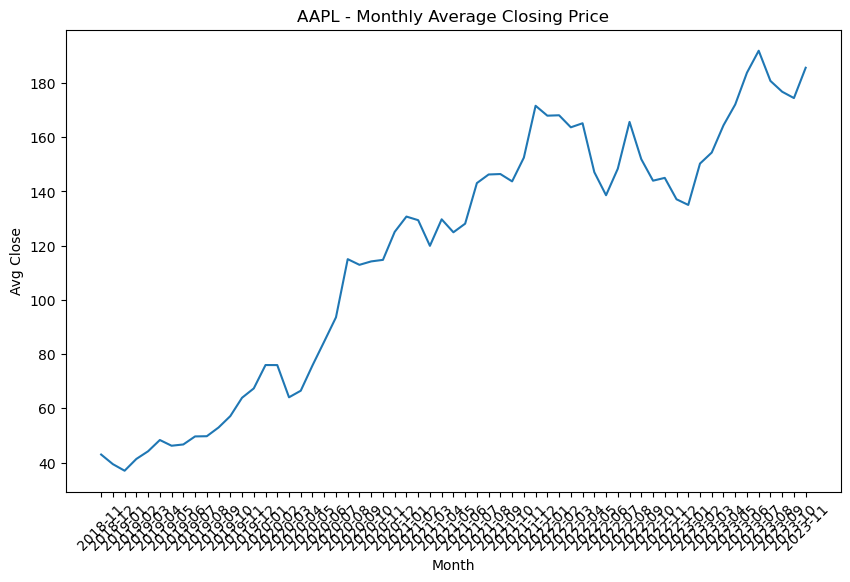

In [23]:
apple_monthly = monthly_avg.filter(col("Company") == "AAPL").toPandas()
plt.figure(figsize=(10,6))
plt.plot(apple_monthly["Month"], apple_monthly["Avg_Close"])
plt.title("AAPL - Monthly Average Closing Price")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Avg Close")
plt.show()

In [24]:
weekly_avg = stock_ts.groupBy("Company", "Year", "Week").agg(avg("Close").alias("Avg_Close")).orderBy("Company", "Year", "Week")
weekly_avg.show(20)

+-------+----+----+-----------------+
|Company|Year|Week|        Avg_Close|
+-------+----+----+-----------------+
|      A|2018|   1| 65.1996002197266|
|      A|2018|  48| 69.3772430419922|
|      A|2018|  49| 69.8351993560791|
|      A|2018|  50|68.23766784667968|
|      A|2018|  51|63.85290298461914|
|      A|2018|  52|  62.863037109375|
|      A|2019|   1|70.76329879760742|
|      A|2019|   2|66.53528900146486|
|      A|2019|   3|68.25951385498048|
|      A|2019|   4|69.78078079223636|
|      A|2019|   5|72.36323852539063|
|      A|2019|   6|73.40898895263672|
|      A|2019|   7|74.55911102294921|
|      A|2019|   8|75.48066520690921|
|      A|2019|   9|76.93087768554688|
|      A|2019|  10|76.41671600341799|
|      A|2019|  11| 77.5262420654297|
|      A|2019|  12|78.10808258056639|
|      A|2019|  13|77.17444610595706|
|      A|2019|  14|78.82173309326171|
+-------+----+----+-----------------+
only showing top 20 rows


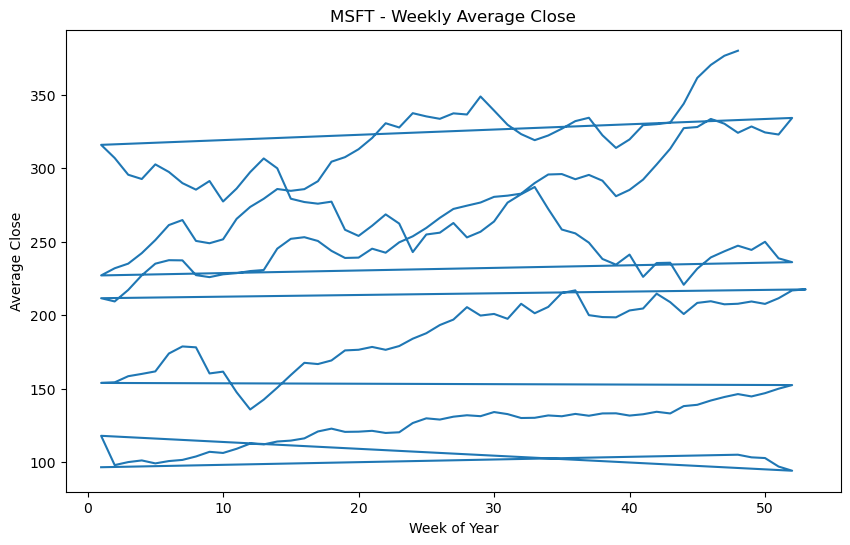

In [25]:
msft_weekly = weekly_avg.filter(col("Company") == "MSFT").toPandas()
plt.figure(figsize=(10,6))
plt.plot(msft_weekly["Week"], msft_weekly["Avg_Close"])
plt.title("MSFT - Weekly Average Close")
plt.xlabel("Week of Year")
plt.ylabel("Average Close")
plt.show()

In [26]:
yearly_avg = stock_ts.groupBy("Company", "Year").agg(avg("Close").alias("Avg_Close")).orderBy("Company", "Year")
yearly_avg.show()

+-------+----+------------------+
|Company|Year|         Avg_Close|
+-------+----+------------------+
|      A|2018| 66.43808982485817|
|      A|2019| 72.92944202725849|
|      A|2020|   90.516794091628|
|      A|2021|142.47105117071243|
|      A|2022| 131.6815232964626|
|      A|2023|127.04814347846019|
|   AAPL|2018| 39.75433749244328|
|   AAPL|2019| 50.42053324078757|
|   AAPL|2020| 93.39436503172863|
|   AAPL|2021|139.02377116490925|
|   AAPL|2022|153.52379574718702|
|   AAPL|2023|170.10774027728618|
|   ABBV|2018| 69.82803017752511|
|   ABBV|2019| 63.70440705617269|
|   ABBV|2020| 78.62976009383975|
|   ABBV|2021|102.70272687881712|
|   ABBV|2022|140.75537148889794|
|   ABBV|2023|145.10240986253496|
|   ABEV|2018|3.4406695933569034|
|   ABEV|2019| 3.948495676593175|
+-------+----+------------------+
only showing top 20 rows


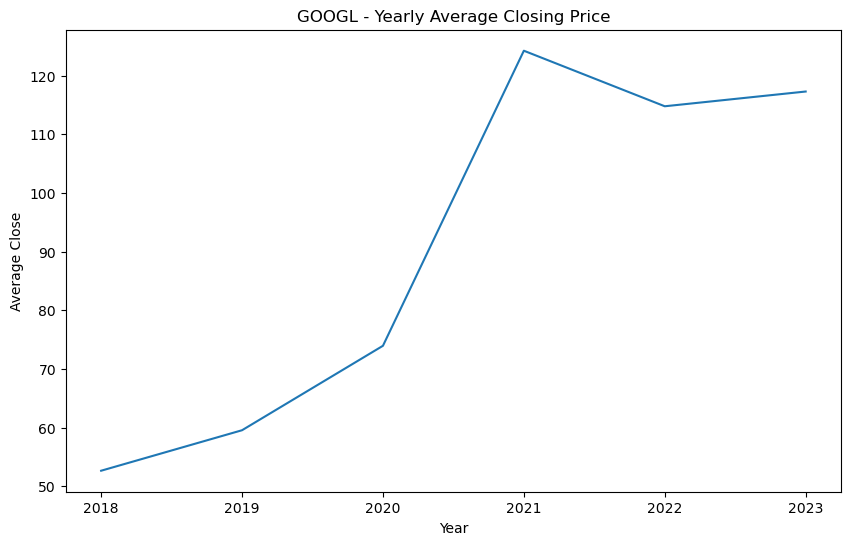

In [27]:
goog_yearly = yearly_avg.filter(col("Company") == "GOOGL").toPandas()
plt.figure(figsize=(10,6))
plt.plot(goog_yearly["Year"], goog_yearly["Avg_Close"])
plt.title("GOOGL - Yearly Average Closing Price")
plt.xlabel("Year")
plt.ylabel("Average Close")
plt.show()

In [28]:
monthly_volume = stock_ts.groupBy("Company", "Month").agg(avg("Volume").alias("Avg_Volume")).orderBy("Company", "Month")
monthly_volume.show()

+-------+-------+------------------+
|Company|  Month|        Avg_Volume|
+-------+-------+------------------+
|      A|2018-11|         2452650.0|
|      A|2018-12|2656526.3157894737|
|      A|2019-01|         2104500.0|
|      A|2019-02|1891668.4210526317|
|      A|2019-03|1562219.0476190476|
|      A|2019-04|1993633.3333333333|
|      A|2019-05|3512131.8181818184|
|      A|2019-06|         2046835.0|
|      A|2019-07|2757786.3636363638|
|      A|2019-08|2546295.4545454546|
|      A|2019-09|         2615060.0|
|      A|2019-10|1492826.0869565217|
|      A|2019-11|         1710850.0|
|      A|2019-12| 1572252.380952381|
|      A|2020-01|1853276.1904761905|
|      A|2020-02| 2296215.789473684|
|      A|2020-03|3219995.4545454546|
|      A|2020-04| 2100461.904761905|
|      A|2020-05|         2390355.0|
|      A|2020-06|         1702150.0|
+-------+-------+------------------+
only showing top 20 rows


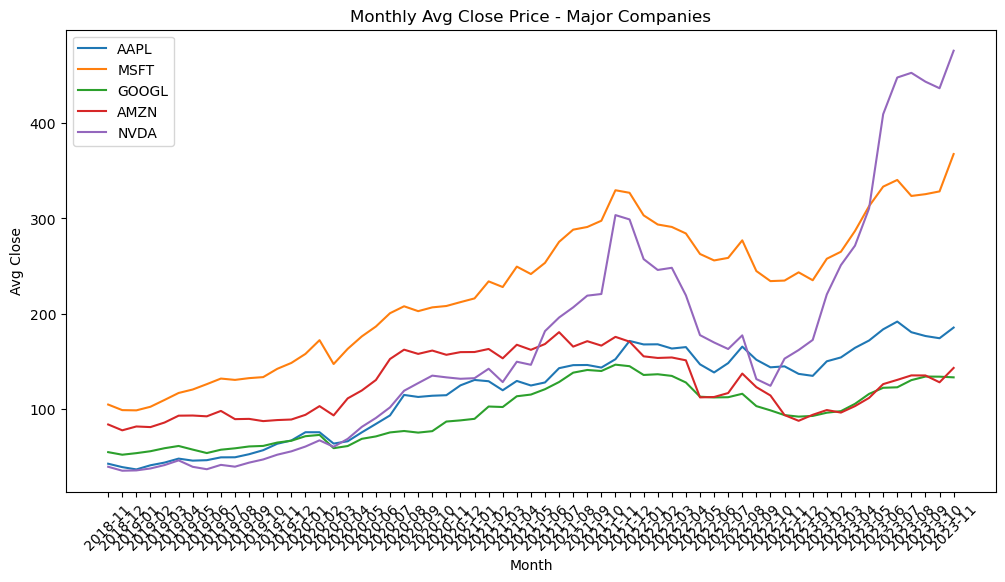

In [29]:
dream_companies = ['AAPL','MSFT','GOOGL','AMZN','NVDA']
plt.figure(figsize=(12,6))

for comp in dream_companies:
    comp_df = monthly_avg.filter(col("Company") == comp).toPandas()
    plt.plot(comp_df["Month"], comp_df["Avg_Close"], label=comp)

plt.title("Monthly Avg Close Price - Major Companies")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Avg Close")
plt.legend()
plt.show()

### ML-N-Problems

In [42]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, lead, when, avg, stddev, mean, expr, sqrt
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, PCA
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.functions import vector_to_array

### Regression: Predict next-day Close using past 7 days

In [33]:
w = Window.partitionBy("Company").orderBy("Date")
df_label = stock_clean_df.withColumn("Close_next", lead("Close", 1).over(w)).dropna(subset=["Close_next"])

lag_days = 14
lag_cols = []
for d in range(1, lag_days + 1):
    for c in ["Open","High","Low","Close","Volume"]:
        name = f"{c}_lag{d}"
        df_label = df_label.withColumn(name, lag(c, d).over(w))
        lag_cols.append(name)

df_label = df_label.withColumn("MA_7", avg("Close").over(w.rowsBetween(-6, 0)))
df_label = df_label.withColumn("MA_14", avg("Close").over(w.rowsBetween(-13, 0)))
df_label = df_label.withColumn("Volatility_7", stddev("Close").over(w.rowsBetween(-6, 0)))
df_label = df_label.withColumn("Daily_Return", col("Close") - lag("Close", 1).over(w))

feature_cols = lag_cols + ["MA_7", "MA_14", "Volatility_7", "Daily_Return"]
df_reg = df_label.dropna(subset=feature_cols + ["Close_next"])
train, test = df_reg.randomSplit([0.8, 0.2], seed=42)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)
gbt = GBTRegressor(featuresCol="features", labelCol="Close_next", seed=42)

pipeline = Pipeline(stages=[assembler, scaler, gbt])
paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth, [5, 8]).addGrid(gbt.maxIter, [50, 100]).addGrid(gbt.stepSize, [0.1]).build()
evaluator = RegressionEvaluator(labelCol="Close_next", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
cvModel = cv.fit(train)
preds = cvModel.transform(test)
rmse = evaluator.evaluate(preds)
r2 = RegressionEvaluator(labelCol="Close_next", predictionCol="prediction", metricName="r2").evaluate(preds)
print("RMSE:", rmse)
print("R2:", r2)
preds.select("Date", "Company", "Close_next", "prediction").show(5)

25/11/23 12:41:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/23 12:43:40 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
25/11/23 12:43:40 WARN DAGScheduler: Broadcasting large task binary with size 1000.8 KiB
25/11/23 12:43:40 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
25/11/23 12:43:40 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
25/11/23 12:43:41 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
25/11/23 12:43:41 WARN DAGScheduler: Broadcasting large task binary with size 1007.1 KiB
25/11/23 12:43:42 WARN DAGScheduler: Broadcasting large task binary with size 1007.7 KiB
25/11/23 12:43:42 WARN DAGScheduler: Broadcasting large task binary with size 1008.9 KiB
25/11/23 12:43:42 WARN DAGScheduler: Broadcasting large task binary with size 1011.2 KiB
25/11/23 12:43:43 WARN DAGScheduler: Broadcasting large task binary with size 1014.0 KiB
25/

RMSE: 129.25167243813902
R2: 0.780831080852893
+-------------------+-------+----------------+------------------+
|               Date|Company|      Close_next|        prediction|
+-------------------+-------+----------------+------------------+
|2018-12-20 00:00:00|   GMAB|16.1299991607666|14.574835800167818|
|2018-12-20 00:00:00|    GIS|32.8617935180664| 32.86702865785346|
|2018-12-20 00:00:00|   AAPL|36.1680679321289|38.064585733900834|
|2018-12-20 00:00:00|     PM|50.7534332275391| 55.71907133354327|
|2018-12-20 00:00:00|    ALL|70.9844589233398| 67.57332005392166|
+-------------------+-------+----------------+------------------+
only showing top 5 rows


### Classification-Predicting Stock Movement Direction (Up/Down) Based on Daily Market Signals

In [34]:
w = Window.partitionBy("Company").orderBy("Date")
df_label = stock_clean_df.withColumn("Close_next", lead("Close", 1).over(w))
df_label = df_label.dropna(subset=["Close_next"])
df_label = df_label.withColumn("UpDown", when(col("Close_next") > col("Close"), 1).otherwise(0))
lag_days = 14
lag_cols = []

for d in range(1, lag_days + 1):
    for c in ["Open", "High", "Low", "Close", "Volume"]:
        name = f"{c}_lag{d}"
        df_label = df_label.withColumn(name, lag(c, d).over(w))
        lag_cols.append(name)

df_label = df_label.withColumn("MA_7", avg("Close").over(w.rowsBetween(-6, 0)))
df_label = df_label.withColumn("MA_14", avg("Close").over(w.rowsBetween(-13, 0)))
df_label = df_label.withColumn("Volatility_7", stddev("Close").over(w.rowsBetween(-6, 0)))
df_label = df_label.withColumn("Daily_Return", col("Close") - lag("Close", 1).over(w))

feature_cols = lag_cols + ["MA_7", "MA_14", "Volatility_7", "Daily_Return"]
df_class = df_label.dropna(subset=feature_cols + ["UpDown"])
df_class = df_class.orderBy("Date")
total_rows = df_class.count()
train_size = int(total_rows * 0.8)
train = df_class.limit(train_size)
test = df_class.subtract(train)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)
rf = RandomForestClassifier(featuresCol="features", labelCol="UpDown", seed=42)
pipeline = Pipeline(stages=[assembler, scaler, rf])
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100, 150])
    .addGrid(rf.maxDepth, [5, 8, 12])
    .build()
)
evaluator = BinaryClassificationEvaluator(labelCol="UpDown", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvModel = cv.fit(train)
preds = cvModel.transform(test)
auc = evaluator.evaluate(preds)
print("Test AUC:", auc)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="UpDown", predictionCol="prediction", metricName="f1"
)
f1 = f1_evaluator.evaluate(preds)
print("F1-score:", f1)
preds.select("Date", "Company", "UpDown", "prediction", "probability").show(10)


25/11/23 13:16:01 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
25/11/23 13:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1759.5 KiB
25/11/23 13:16:11 WARN DAGScheduler: Broadcasting large task binary with size 1359.5 KiB
25/11/23 13:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
25/11/23 13:16:39 WARN DAGScheduler: Broadcasting large task binary with size 1759.5 KiB
25/11/23 13:16:44 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/23 13:16:49 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/11/23 13:16:55 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
25/11/23 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1125.6 KiB
25/11/23 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
25/11/23 13:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1547.6 KiB
25/11/23 13:17:12 WARN DAGSchedul

Test AUC: 0.5004598369619235


25/11/23 13:49:50 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB
                                                                                

F1-score: 0.40944012306322297


25/11/23 13:50:03 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB


+-------------------+-------+------+----------+--------------------+
|               Date|Company|UpDown|prediction|         probability|
+-------------------+-------+------+----------+--------------------+
|2022-12-08 00:00:00|   HSBC|     1|       1.0|[0.46384993939639...|
|2022-12-08 00:00:00|   NVDA|     0|       0.0|[0.52297406094586...|
|2022-12-08 00:00:00|    UPS|     0|       0.0|[0.50258722790605...|
|2022-12-08 00:00:00|   VRSN|     1|       1.0|[0.45622418845746...|
|2022-12-08 00:00:00|     EL|     0|       1.0|[0.49246799508232...|
|2022-12-08 00:00:00|    MFG|     1|       0.0|[0.51335468514244...|
|2022-12-08 00:00:00|    VOD|     1|       1.0|[0.49054544868824...|
|2022-12-08 00:00:00|    XEL|     1|       1.0|[0.47314935191266...|
|2022-12-08 00:00:00|    SRE|     0|       1.0|[0.47041396286026...|
|2022-12-08 00:00:00|   ORCL|     0|       1.0|[0.48483400514482...|
+-------------------+-------+------+----------+--------------------+
only showing top 10 rows


### Clustering

In [43]:
w = Window.partitionBy("Company").orderBy("Date")
df_label = (
    stock_clean_df
    .withColumn("Close_next", lead("Close", 1).over(w))
    .dropna(subset=["Close_next"])
)
lag_days = 14
lag_cols = []
for d in range(1, lag_days + 1):
    for c in ["Open", "High", "Low", "Close", "Volume"]:
        name = f"{c}_lag{d}"
        df_label = df_label.withColumn(name, lag(c, d).over(w))
        lag_cols.append(name)

df_label = df_label.withColumn("MA_7", avg("Close").over(w.rowsBetween(-6, 0)))
df_label = df_label.withColumn("MA_14", avg("Close").over(w.rowsBetween(-13, 0)))
df_label = df_label.withColumn("Volatility_7", stddev("Close").over(w.rowsBetween(-6, 0)))
df_label = df_label.withColumn("Daily_Return", col("Close") - lag("Close", 1).over(w))

feature_cols = lag_cols + ["MA_7", "MA_14", "Volatility_7", "Daily_Return"]
df_reg = df_label.dropna(subset=feature_cols + ["Close_next"])
agg_exprs = [
    avg("Close").alias("avg_close"),
    stddev("Close").alias("volatility"),
    avg("Volume").alias("avg_volume"),
    stddev("Daily_Return").alias("return_std")
]

df_agg = df_reg.groupBy("Company").agg(*agg_exprs)
assembler = VectorAssembler(inputCols=["avg_close", "volatility", "avg_volume", "return_std"], outputCol="features_unscaled")
df_vector = assembler.transform(df_agg)
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)
df_scaled = scaler.fit(df_vector).transform(df_vector)
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="prediction")
model = kmeans.fit(df_scaled)
df_clustered = model.transform(df_scaled)
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)
df_pca_array = df_pca.withColumn("pca_array", vector_to_array("pca_features"))
df_pca_array = df_pca_array.withColumn("PC1", col("pca_array")[0]).withColumn("PC2", col("pca_array")[1])
df_plot = df_pca_array.select("Company", "PC1", "PC2").join(
    df_clustered.select("Company", "prediction"), on="Company"
)
df_plot.show(truncate=False)

+-------+---------------------+--------------------+----------+
|Company|PC1                  |PC2                 |prediction|
+-------+---------------------+--------------------+----------+
|AAPL   |0.7208670603636876   |8.414989185709246   |2         |
|ALL    |0.3302070775790583   |-0.3863726695409452 |0         |
|ARM    |0.5885413936251059   |-0.10167207472695869|0         |
|AXP    |0.07746283042622325  |-0.2009782509778287 |0         |
|BEKE   |0.5608064445693721   |0.2780761829453722  |0         |
|BLK    |-2.8517029161263343  |-0.233084208687746  |0         |
|CDW    |-0.039537318249076886|-0.4428129349206679 |0         |
|CI     |-0.4464869541607642  |-0.3155491248251654 |0         |
|CRWD   |-0.5017627847922485  |-0.0975245636058284 |0         |
|CSCO   |0.8024578886355813   |1.246007733035691   |0         |
|DUK    |0.5037035781174554   |-0.2877641768261518 |0         |
|EA     |0.2828909613186105   |-0.29732307837893823|0         |
|FI     |0.3802781684291478   |-0.205911

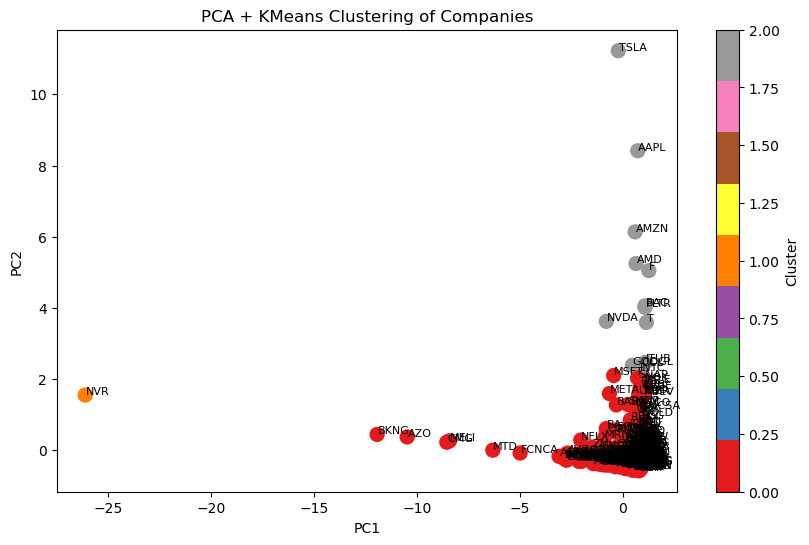

In [44]:
plot_data = df_plot.collect()
companies = [row["Company"] for row in plot_data]
pc1 = [row["PC1"] for row in plot_data]
pc2 = [row["PC2"] for row in plot_data]
clusters = [row["prediction"] for row in plot_data]
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pc1, pc2, c=clusters, cmap="Set1", s=100)
for i, company in enumerate(companies):
    plt.text(pc1[i]+0.02, pc2[i]+0.02, company, fontsize=8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA + KMeans Clustering of Companies")
plt.colorbar(scatter, label="Cluster")
plt.show()

### Forecasting

In [47]:
company = "AAPL"
series_df = stock_clean_df.filter(col("Company") == company).orderBy("Date")
lag_days = 10
forecast_horizon = 5
for i in range(1, lag_days + 1):
    series_df = series_df.withColumn(f"lag_{i}", lag("Close", i).over(Window.orderBy("Date")))
for h in range(1, forecast_horizon + 1):
    series_df = series_df.withColumn(f"Close_next_{h}", lag("Close", -h).over(Window.orderBy("Date")))
lag_cols = [f"lag_{i}" for i in range(1, lag_days + 1)]
target_cols = [f"Close_next_{h}" for h in range(1, forecast_horizon + 1)]
series_df = series_df.dropna(subset=lag_cols + target_cols)
forecast_models = []
for target in target_cols:
    assembler = VectorAssembler(inputCols=lag_cols, outputCol="features_unscaled")
    scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)
    gbt = GBTRegressor(featuresCol="features", labelCol=target, maxIter=100, maxDepth=5, seed=42)
    pipeline = Pipeline(stages=[assembler, scaler, gbt])
    model = pipeline.fit(series_df)
    forecast_models.append(model)
last_row = series_df.orderBy(col("Date").desc()).first()
current_lags = [last_row[f"lag_{i}"] for i in range(1, lag_days + 1)]

forecast_values = []
for i, model in enumerate(forecast_models):
    pred_row = spark.createDataFrame([Row(**{f"lag_{j+1}": current_lags[j] for j in range(lag_days)})])
    pred_features = model.stages[0].transform(pred_row)
    pred_features = model.stages[1].transform(pred_features)
    pred = model.stages[2].transform(pred_features).collect()[0]["prediction"]
    forecast_values.append(pred)
    current_lags = current_lags[1:] + [pred]

print("Next 5 days forecast:", forecast_values)


25/11/23 14:21:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 14:21:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 14:21:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 14:21:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 14:21:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 14:21:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 1

Next 5 days forecast: [191.2467524454713, 190.56697458688174, 190.78911980342582, 190.2952272453026, 192.17720525745514]
